In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import re
import os
import os.path as osp
import sys
import time
import glob
import cv2
from tqdm import tqdm, tnrange, tqdm_notebook
from collections import OrderedDict
import PIL
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch import Tensor
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split, Subset

import torchvision
from torchvision import datasets, models

from mpl_toolkits.axes_grid1 import ImageGrid

from dataset import COCODataset
from dataset import variable_shape_collate_fn

from utils import postprocessing, letterbox_transforms, letterbox_label_reverse
from draw import show_img, draw_rect, draw_text, \
                 cv2_drawTextWithBkgd, get_color_pallete
from darknet import YoloNet
from train import *
from utils import load_image
import transforms
from transforms import BoundingBoxFormatConvert,ToX1y1x2y2Abs, ToCxcywhRel, ToIaa, iaa_hsv_aug, iaa_random_crop, iaa_letterbox, \
                       IaaAugmentations, ToNp, IaaLetterbox, ToTensor, Compose
from boundingbox import bbox_x1y1x2y2_to_xywh, bbox_x1y1x2y2_to_cxcywh, bbox_cxcywh_to_x1y1x2y2, bbox_cxcywh_to_xywh, \
                        bbox_xywh_to_cxcywh, bbox_xywh_to_x1y1x2y2, CoordinateType, FormatType, BoundingBoxConverter
    
from imgaug import augmenters as iaa

# Paths

In [2]:
CUDA = True
use_cuda = True
weight_path = './yolov3.weights'
backbone_weight_path = './darknet53.conv.74'
coco_path = './data/coco.names'
train_target_txt = "./data/coco/trainvalno5k.txt"
valid_target_txt = "./data/coco/5k.txt"

In [3]:
cv2.setNumThreads(0)

In [4]:
def getTransforms(dim, bbs_idx=np.arange(0,4),
                  coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=True):
    if aug:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaAugmentations([iaa_hsv_aug(0.1, 1.5, 1.5),
                                               iaa_random_crop(0.3),
                                               iaa.Fliplr(0.5)
                                              ]),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    else:
        transform = Compose([ToX1y1x2y2Abs(coord_type, format_type, bbs_idx),
                             ToIaa(bbs_idx),
                             IaaLetterbox(dim),
                             ToNp(bbs_idx),
                             ToCxcywhRel(CoordinateType.Absolute, FormatType.x1y1x2y2, bbs_idx),
                             ToTensor()])
    return transform

In [5]:
def getData(sz, bs, valid_subset_idx=None, train_subset_idx=None, shuffle=True, isAug=True):
    dim = (sz, sz)
    
    transform_train = getTransforms(dim, bbs_idx=np.arange(1,5), coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=isAug)
    transform_valid = getTransforms(dim, bbs_idx=np.arange(1,5), coord_type=CoordinateType.Relative, format_type=FormatType.cxcywh, aug=False)
    
    train_ds = COCODataset(train_target_txt, dim=dim, bbs_idx=np.arange(1,5), transform=transform_train)
    valid_ds = COCODataset(valid_target_txt, dim=dim, bbs_idx=np.arange(1,5), transform=transform_valid)
    
    if train_subset_idx is not None:
        train_ds = Subset(train_ds, train_subset_idx)
    if valid_subset_idx is not None:
        valid_ds = Subset(valid_ds, valid_subset_idx)
        
    
    train_dl = DataLoader(train_ds, batch_size=bs, shuffle=shuffle, collate_fn=variable_shape_collate_fn, num_workers=4)
    valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=shuffle, collate_fn=variable_shape_collate_fn, num_workers=4)
    
    
    dataloader = dict()
    dataloader['train'] = train_dl
    dataloader['valid'] = valid_dl
    
    return dataloader

## Initial Training

In [6]:
sz = 416
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
darknet53_lr = 0.0001 / ratio
momentum=0.9
wd=0.0005
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 4
bs = int(net_bs / net_subdivisions)
# Learning rate scheduler parameters. Not used at the moment
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1

In [ ]:
epoch = 100
model_id = 'COCO_2'
weight_dir = './weights'

#remove_checkpoints(model_id, weight_dir_path)

net = YoloNet((sz, sz)).cuda()
net.feature.loadWeight(backbone_weight_path) # Load backbone darknet53 weight
#net.loadWeight(pt_weight_path) # Load pretrained pytorch weight
#net.loadWeight(weight_path, 'darknet') # Load full yolo v3 weight

train(getData(sz, bs, shuffle=True, isAug=True), net, epoch,
              lr, darknet53_lr, 
              wd=wd, momentum=momentum, freeze_backbone=False,
              lr_step_decay=0, lr_step_gamma=0,
              net_bs=net_bs, net_subdivisions=net_subdivisions,
              model_id=model_id, start_epoch=0, weight_dir=weight_dir, checkpoint_interval=1,
              resume_checkpoint=None,
              use_gpu=True)


## Resume training (make sure 'model_id' matches)

In [6]:
sz = 416
# Optimizer parameters
ratio = 1
lr = 0.001 / ratio
darknet53_lr = 0.0001 / ratio
momentum=0.9
wd=0.0005
# Network paramters. Increase subdivisions if GPU don't have enough memory
net_bs = 64
net_subdivisions = 4
bs = int(net_bs / net_subdivisions)
# Learning rate scheduler parameters. Not used at the moment
lr_scheduler_decay_step = 20
lr_scheduler_decay_gamma = 0.1

In [7]:
def resume_training(max_epoch, model_id, weight_dir):
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir)
    if pt_weight_path is not None:
        print('Loading %s' % pt_weight_path)
        
        checkpoint = load_checkpoint(pt_weight_path)
        net = YoloNet((sz, sz)).cuda()
        
        train(getData(sz, bs, shuffle=True, isAug=True), net, epoch,
              lr, darknet53_lr, 
              wd=wd, momentum=momentum, freeze_backbone=False,
              lr_step_decay=0, lr_step_gamma=0,
              net_bs=net_bs, net_subdivisions=net_subdivisions,
              model_id=model_id, start_epoch=latest_epoch+1, weight_dir=weight_dir, checkpoint_interval=1,
              resume_checkpoint=checkpoint,
              use_gpu=True)
                         
    else:
        print('No checkpoint for %s found' % model_id)

In [ ]:
epoch = 300
model_id = 'COCO_2'
weight_dir = './weights'
resume_training(epoch, model_id, weight_dir)

## Test intermediate models

In [14]:
def load_coco(path):
    with open(path) as f:
        return [line.rstrip("\n") for line in f.readlines()]

def show_output(img, dets, cls_names):
    ax = show_img(img, figsize=(16,8))
    for d in dets:
        rect = bbox_x1y1x2y2_to_xywh(d)
        draw_rect(ax, rect[:4])
        c = cls_names[d[-1].int().item()]
        draw_text(ax, rect[:2], c)

def test_intermediate_model(model_id):
    sz = 416
    bs = 4
    dim = (sz, sz)
    
    coco_path = './coco.names'
    classes_names = load_coco(coco_path)

    
    weight_dir_path = './weights'
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir_path)

    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    
    net = YoloNet(dim).cuda().eval()
    #net.loadWeight(weight_path, 'darknet') # Load full yolo v3 weight
    net.load_state_dict(checkpoint['net'])
    train_dl = getData(sz, bs, shuffle=False, isAug=False)['train']
    
    with torch.no_grad():
        for batch, sample in enumerate(train_dl):
            if batch != 1:
                continue
            
            img = sample['img']
            det1,det2,det3 = net(img.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 80, obj_conf_thr=0.5, nms_thr=0.4)
            for img, p in zip(img, predictions):
                label = p[..., [0,1,2,3,6]] if len(p) !=0 else p
                show_output(img.permute(1,2,0), label, classes_names)
            #Run only one batch
            break

Loading ./weights/COCO_2/yolov3_COCO_2_checkpoint_0188.pth.tar


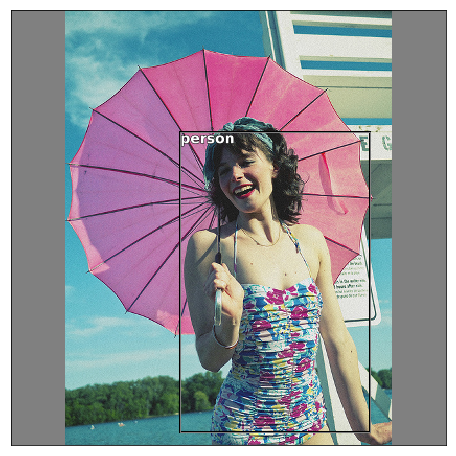

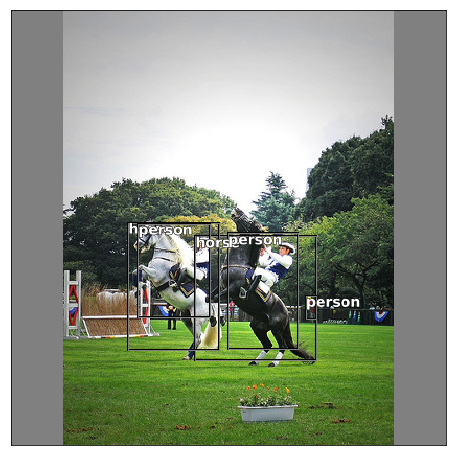

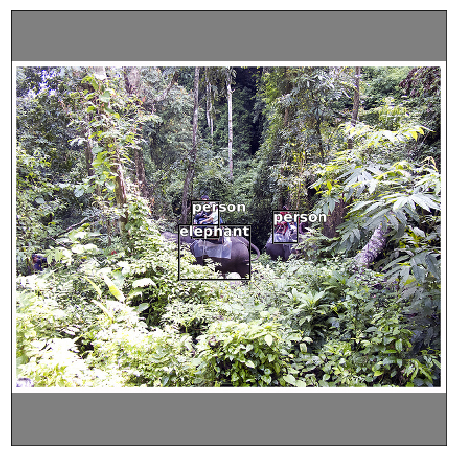

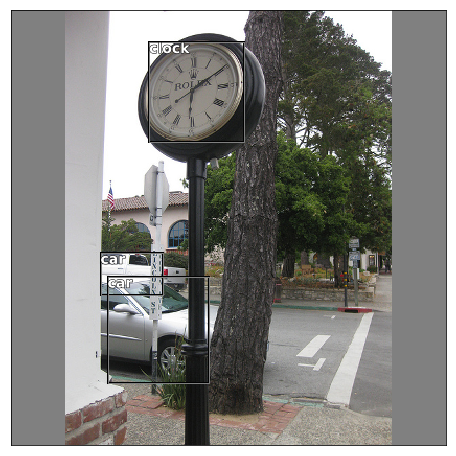

In [15]:
test_intermediate_model('COCO_2')

In [16]:
def test_on_images(model_id, img_dir):
    sz = 416
    bs = 4
    dim = (sz, sz)
    
    coco_path = './coco.names'
    classes_names = load_coco(coco_path)

    
    weight_dir_path = './weights'
    pt_weight_path, latest_epoch = get_latest_checkpoint(model_id, weight_dir_path)

    print('Loading %s' % pt_weight_path)
    checkpoint = load_checkpoint(pt_weight_path)
    
    net = YoloNet(dim).cuda().eval()
    ##net.loadWeight(weight_path, 'darknet') # Load full yolo v3 weight
    net.load_state_dict(checkpoint['net'])
    
    img_list = os.listdir(img_dir)
    
    with torch.no_grad():
        for i, img_path in enumerate(img_list):
            
            img_path = osp.join(img_dir, img_path)
            img, _ = load_image(img_path, mode='letterbox', dim=(416,416))
            img = img.unsqueeze(0)
            det1,det2,det3 = net(img.cuda(), None)
            predictions = postprocessing(torch.cat((det1,det2,det3), 1), 80, obj_conf_thr=0.5, nms_thr=0.4)
            for img, p in zip(img, predictions):
                label = p[..., [0,1,2,3,6]] if len(p) !=0 else p
                show_output(img.permute(1,2,0), label, classes_names)
            #Run only one batch
            #break

In [ ]:
test_on_images('COCO_2', './imgs')